In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.directories import processed_data_dir, saved_model_dir, vis_dir
from src.data_prep import WindowGenerator, get_filenames_in_directory

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_dir = processed_data_dir / 'train'
val_dir = processed_data_dir / 'val'
test_dir = processed_data_dir / 'test'

In [6]:
train_files = get_filenames_in_directory(train_dir)

In [7]:
# number of features
# 11
cols = pd.read_csv(train_dir/train_files[0]).columns
n_features = len(cols) -1  # number of columns without embedding column
n_features

11

In [8]:
# number of locations for embedding inputs
# 6
train_files = get_filenames_in_directory(train_dir)
n_locations = len(train_files)
n_locations

6

In [9]:
# Model configs
INPUT_WIDTH = 24  * 3
LABEL_WIDTH = 24
BATCH_SIZE = 32
N_FEATURES = n_features
N_OUTPUTS = 1
N_EMBEDDING_DIMS = n_locations

In [10]:
w1 = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, batch_size=BATCH_SIZE,
                     train_dir=train_dir, val_dir=val_dir, test_dir=test_dir,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')

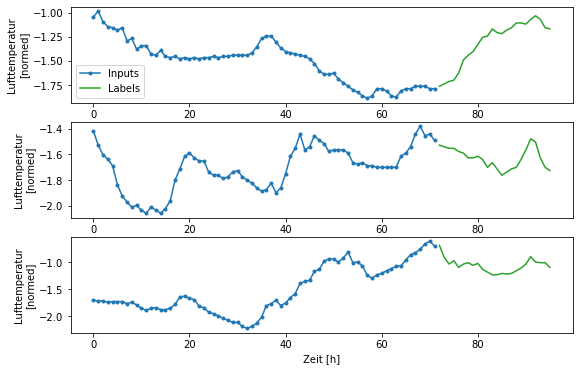

In [18]:
w1.plot(rotate_examples=False)

In [24]:
# container to store model performances
performance = {}

# Baseline model 1: Repeat last hour

In [34]:
for i in w1.train.take(1):
    print(i[0][0])

tf.Tensor(
[[[ 5.31880558e-01 -6.85310423e-01  4.69001979e-01 ...  2.59668232e-05
    2.25184098e-01  1.39572597e+00]
  [ 5.31880558e-01 -8.34011197e-01  9.57157433e-01 ... -3.66002440e-01
    2.26184845e-01  1.39556408e+00]
  [ 6.67666674e-01 -8.83578122e-01  1.01139688e+00 ... -7.07086623e-01
    2.27185488e-01  1.39540136e+00]
  ...
  [-1.12641053e-02 -6.35743499e-01  9.02917922e-01 ...  1.00003421e+00
    2.93936193e-01  1.38287330e+00]
  [-1.47050261e-01 -5.98568261e-01  8.48678410e-01 ...  7.07138598e-01
    2.94927716e-01  1.38266206e+00]
  [-1.47050261e-01 -5.73784828e-01  8.48678410e-01 ...  3.66054386e-01
    2.95919091e-01  1.38245010e+00]]

 [[ 1.24522053e-01 -1.66425741e+00 -1.04970384e+00 ...  2.59668195e-05
    9.22654644e-02  1.41078126e+00]
  [ 1.24522053e-01 -1.54034007e+00 -1.37514079e+00 ...  3.66054386e-01
    9.32770446e-02  1.41071463e+00]
  [ 1.24522053e-01 -1.50316477e+00 -1.48361981e+00 ...  7.07138598e-01
    9.42885801e-02  1.41064715e+00]
  ...
  [-2.828364

In [42]:
class LastStepBaseline(tf.keras.Model):
  def call(self, inputs):
    features, _ = inputs
    return tf.tile(features[:, -1:, :], [1, LABEL_WIDTH, 1])

last_step_baseline = LastStepBaseline()
last_step_baseline.compile(loss=tf.losses.MeanSquaredError(),
                           metrics=[tf.metrics.MeanAbsoluteError()])

In [49]:
pred = last_step_baseline.predict(w1.test)

In [52]:
pred.shape

(17334, 24, 11)

1092/1092 [==============================] - 11s 10ms/step - loss: 2.4794 - mean_absolute_error: 1.2618


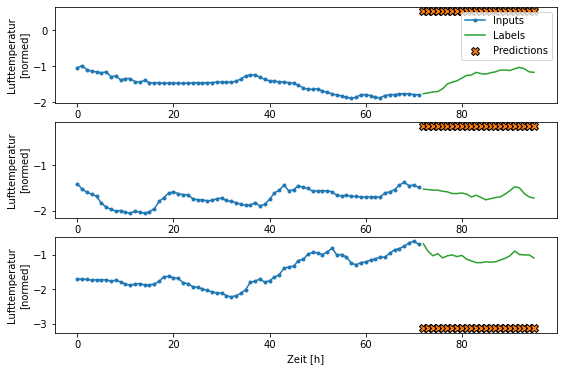

In [43]:
performance['last_step_baseline '] = last_step_baseline.evaluate(w1.val)
performance['last_step_baseline'] = last_step_baseline.evaluate(w1.test, verbose=0)

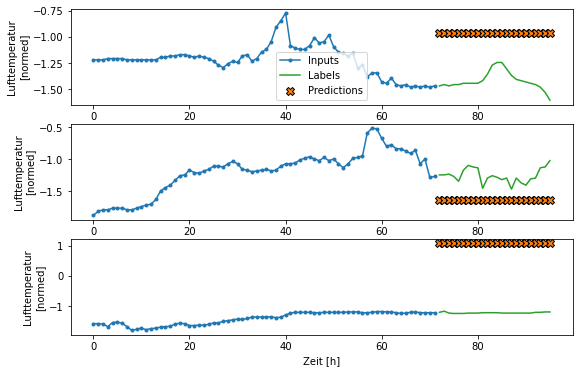

In [54]:
w1.plot(last_step_baseline, rotate_examples=True)

# Define model & metrics

In [43]:
tf.keras.backend.clear_session()

# Input for embeddings
embedding_inputs = tf.keras.Input(shape =(INPUT_WIDTH,))
embedding_layer = tf.keras.layers.Embedding(input_dim=N_EMBEDDING_DIMS + 1, 
                                            output_dim=2, input_length=INPUT_WIDTH)(embedding_inputs)

# Input for features
feature_inputs = tf.keras.layers.Input(shape=(INPUT_WIDTH, n_features))

# Concat embeddings &  features
concat_layer = tf.keras.layers.Concatenate()([embedding_layer, feature_inputs])

lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(concat_layer)
lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(lstm_layer)
lstm_layer = tf.keras.layers.LSTM(13, return_sequences=True)(lstm_layer)[:,-LABEL_WIDTH:,:]

# Apply a dense output layer on every timestep of the LSTM
output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=1, activation='linear')
)(lstm_layer)

# Build the model
model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

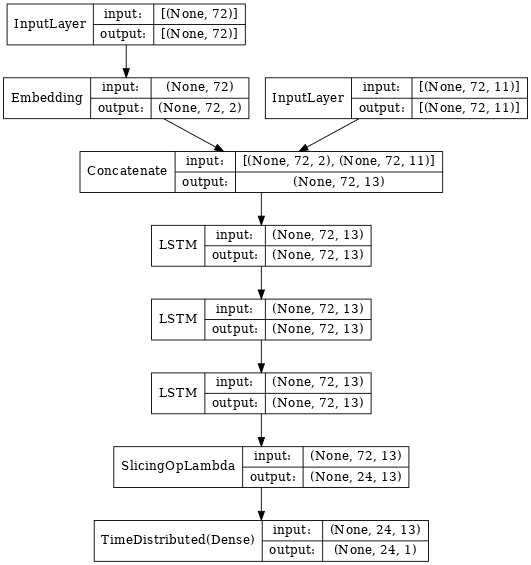

In [18]:
tf.keras.utils.plot_model(
    model, to_file=vis_dir/'forecast_model_architecture.png', show_shapes=True, 
    show_layer_names=False, rankdir='TB', expand_nested=False, dpi=64
)

# Train model

In [45]:
# Train configs
MAX_EPOCHS = 30

In [46]:
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='MAE')
]

In [47]:
def compile_and_fit(model,
                    train_dataset,
                    validation_dataset,
                    save_to=None, 
                    patience=3, 
                    lr=1e-4, 
                    max_epochs=MAX_EPOCHS,
                    metrics=METRICS,
                    batch_size=BATCH_SIZE,
                    verbose=True):

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights=True)
    
    save_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_to,
                                                         save_weights_only=False,
                                                         monitor='val_loss',
                                                         mode='min',
                                                         save_best_only=True,
                                                         save_freq='epoch')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(lr=lr),
                metrics=metrics)

    history = model.fit(train_dataset, epochs=max_epochs,
                      validation_data=validation_dataset,
                      callbacks=[early_stopping],  # save_checkpoint not used atm
                      batch_size=batch_size,
                      verbose=verbose)
                      
    return history

In [48]:
model_name = 'lstm_basic_' + \
        datetime.datetime.today().strftime('%y%m%d')

history = compile_and_fit(model, w1.train, w1.val, save_to=str(saved_model_dir/model_name))

Epoch 1/30
3282/3282 [==============================] - 185s 55ms/step - loss: 0.5134 - MAE: 0.5454 - val_loss: 0.2019 - val_MAE: 0.3490
Epoch 2/30
3282/3282 [==============================] - 232s 71ms/step - loss: 0.1876 - MAE: 0.3358 - val_loss: 0.1734 - val_MAE: 0.3241
Epoch 3/30
3282/3282 [==============================] - 254s 77ms/step - loss: 0.1670 - MAE: 0.3168 - val_loss: 0.1652 - val_MAE: 0.3177
Epoch 4/30
3282/3282 [==============================] - 243s 74ms/step - loss: 0.1564 - MAE: 0.3063 - val_loss: 0.1569 - val_MAE: 0.3098
Epoch 5/30
3282/3282 [==============================] - 301s 92ms/step - loss: 0.1473 - MAE: 0.2966 - val_loss: 0.1491 - val_MAE: 0.3004
Epoch 6/30
3282/3282 [==============================] - 217s 66ms/step - loss: 0.1409 - MAE: 0.2891 - val_loss: 0.1468 - val_MAE: 0.2984
Epoch 7/30
3282/3282 [==============================] - 295s 90ms/step - loss: 0.1363 - MAE: 0.2837 - val_loss: 0.1459 - val_MAE: 0.2977
Epoch 8/30
3282/3282 [===================

In [49]:
model.save(str(saved_model_dir/model_name))

[2021-08-29 12:01:46 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.
[2021-08-29 12:01:46 | save] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210829/assets


[2021-08-29 12:01:48 | builder_impl] Assets written to: /home/heckert/projects/sbg-weather/data/saved_models/lstm_basic_210829/assets


Text(0, 0.5, 'val_loss')

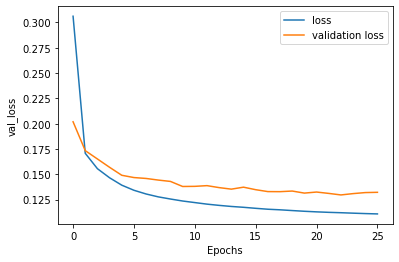

In [50]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(labels = ["loss", "validation loss"])
plt.xlabel("Epochs")
plt.ylabel("val_loss")

In [51]:
model.evaluate(w1.test)

546/546 [==============================] - 20s 35ms/step - loss: 0.1397 - MAE: 0.2813


[0.13966414332389832, 0.2813224494457245]

In [11]:
model = tf.keras.models.load_model(saved_model_dir/'lstm_basic_210829')

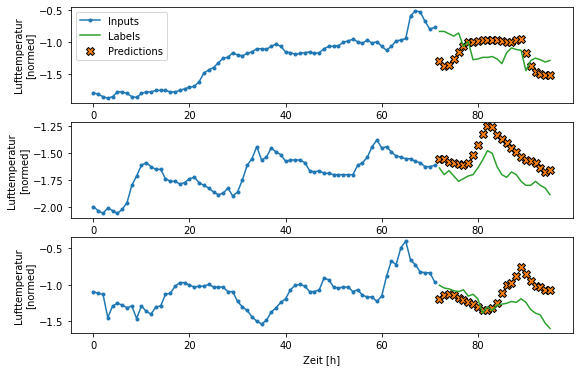

In [18]:
w1.plot(model=model)